# Подготовка датасета

In [1]:
!pip install json5 gdown sentence-transformers -q

In [2]:
# Загрузка необходимых данных из облака
!gdown --id 1UVmzKjP8loCkghhX_MsehMbXhalsD3wz
!gdown --id 16EsI225xsx6SnCVnYD2HAWQKvl_u2--q
!gdown --id 1tbiXsGso2ym98SQFJF8IFmolAz8mcz-J
!gdown --id 1uvWWb-wI7YSmTndI8_hBjAzoGOxGwtdC

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1UVmzKjP8loCkghhX_MsehMbXhalsD3wz
To: /kaggle/working/ru_trl_test.json
100%|██████████████████████████████████████| 4.85M/4.85M [00:00<00:00, 58.3MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16EsI225xsx6SnCVnYD2HAWQKvl_u2--q
To: /kaggle/working/geo_only.json
100%|█████████████████████████████████████████| 244k/244k [00:00<00:00, 105MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. Y

In [3]:
import json5
import sqlite3
from tqdm import tqdm
import os, re, time
import torch
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt

In [4]:
conn = sqlite3.connect('geo.sqlite')
db = conn.cursor()

In [5]:
schema = open('schema.sql').read()
try:
    db.execute('SELECT * FROM state')
except:
    db.executescript(schema)
    
geo_only = json5.loads(open('geo_only.json').read())

# Краткий инференс моделей

| model               | accuracy | sql sim. | mean exec. time (20 samples) | RAM   | GPU Mem. |
|---------------------|----------|----------|------------------------------|-------|----------|
| sqlcoder-7b-2       | **0.15**     | 0.741    |             2.438            | ~**7gb**  | ~14gb    |
| Chat2DB-SQL-7B      | **0.15**     | **0.839**    |             **1.509**            | ~8gb  | ~**8gb**    |
| DuckDB-NSQL-7B-v0.1 | 0.05     | 0.762    |             1.669            | ~8gb  | ~14gb    |
| _internlm2_5-7b_     | 0.0      | 0.483    |            33.231            | ~10gb | ~20gb    |

Как видно из таблицы, лучше всего себя показала модель Chat2DB-SQL-7B, хуже всего - internlm. Однако на данный момент эти данные мало о чём говорят потому, что, во-первых, для сравнения таблиц используется "сырое" равенство между двумя python-массивами, во-вторых, в промпте указано довольно-таки мало информации (например, отсутствует Cell Value Reference и Schema Linking), в-третьих, модель _internlm2_5-7b_ вовсе является моделью общего назначения и пока что ведёт себя непредсказуемо (на запрос на естественном языке может выдать множество SQL-запросов с пояснениями, хотя в промпте просили выдавать ответ без них).

In [6]:
# Пришлось по отдельности вычислять значения моделей на датасете, т.к среда не тянет больше одной LLM-ки одновременно. Или тянет, но тогда это сильно сказывается на скорости выполнения
sqlcoder = [2.2369444370269775, 1.2355380058288574, 1.8206593990325928, 4.242553472518921, 2.7599916458129883, 4.4950525760650635, 1.7857539653778076, 1.8319032192230225, 4.249694347381592, 1.1512413024902344, 1.9609730243682861, 1.7273619174957275, 2.6429495811462402, 2.5273468494415283, 2.9637715816497803, 2.5321526527404785, 2.4652719497680664, 1.9069654941558838, 1.8566584587097168, 2.3530471324920654]
chat2db = [2.482621192932129, 1.2067625522613525, 1.2091491222381592, 2.3402109146118164, 1.03086256980896, 1.5266852378845215, 0.9082696437835693, 1.4127106666564941, 1.2485144138336182, 0.9084548950195312, 0.966902494430542, 1.5396132469177246, 2.2168426513671875, 1.6644635200500488, 1.3834388256072998, 1.7178280353546143, 1.097515344619751, 1.7943229675292969, 1.7270333766937256, 1.7964227199554443]
duckdb = [2.076850414276123, 1.3486504554748535, 1.2256524562835693, 1.2257285118103027, 3.560006856918335, 1.7321102619171143, 1.916945219039917, 1.5647597312927246, 1.6077048778533936, 1.233952522277832, 1.5506513118743896, 1.297882318496704, 2.118703842163086, 2.3147096633911133, 1.934046745300293, 1.3695087432861328, 1.3092124462127686, 1.3505096435546875, 1.3129842281341553, 1.3219778537750244]
internlm = [35.891454458236694, 33.713053464889526, 33.48268175125122, 32.682185649871826, 31.122331380844116, 33.83864378929138, 32.84711718559265, 32.28859829902649, 31.499861240386963, 33.736652135849, 33.76218771934509, 33.92374777793884, 32.96854782104492, 32.44618511199951, 32.29519033432007, 33.73952555656433, 34.07122468948364, 33.43252372741699, 33.668530225753784, 33.208176612854004]

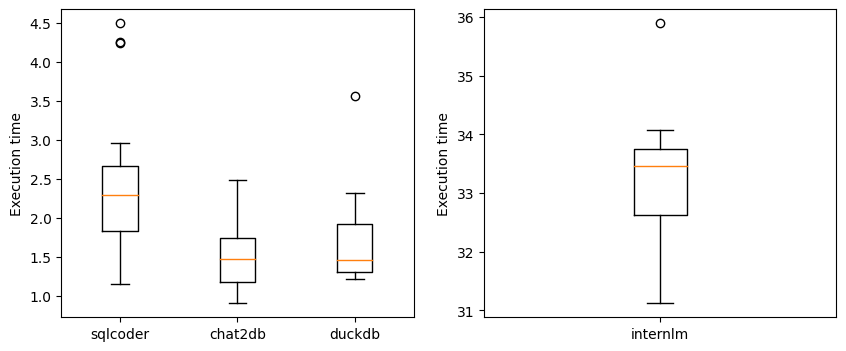

In [7]:
ax, (fig1, fig2) = plt.subplots(ncols=2, figsize=(10, 4))
fig1.set_ylabel('Execution time')
fig1.boxplot([sqlcoder, chat2db, duckdb], labels=['sqlcoder', 'chat2db', 'duckdb'])
fig2.set_ylabel('Execution time')
_ = fig2.boxplot([internlm], labels=['internlm'])

# Запуск моделей

In [8]:
sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
prompt = '''
### Ответь на вопрос SQLite sql-запросом и без объяснений. Минимизируй время выполнения sql-запроса без потери точности.
### Схемы таблиц указаны ниже:

{}

### Вопрос: {}
### SQL:
'''

In [12]:
def table_similarity(table1, table2):
    set1 = set(tuple(row) for row in table1)
    set2 = set(tuple(row) for row in table2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 1.0  # Если обе таблицы пустые, считатаем совпадение полным.


In [13]:
class HuggingFaceModelInference: # Запуски HuggingFace моделей схожи между собой, поэтому решил инкапсулировать это дельце
    def __init__(self, path):
        self.path = path
        self.evaluated = False
        self.is_downloaded = False
        
    def evaluate(self, samples, prompt_base, prompt_schema):
        if not self.is_downloaded:
            self.tokenizer = AutoTokenizer.from_pretrained(self.path, trust_remote_code=True)
            self.model = AutoModelForCausalLM.from_pretrained(self.path,torch_dtype=torch.float16,trust_remote_code=True, device_map='auto')
            self.is_downloaded = True

        output_log = []
        eq_cnt = 0
        exception_cnt = 0
        exec_time = []
        for sample in tqdm(samples):
            question = sample['question']
            ground_query = sample['query']
    
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token
        
            st = time.time()
            inputs = self.tokenizer(prompt_base.format(prompt_schema, question), return_tensors='pt').to('cuda')
            generate_ids = self.model.generate(inputs.input_ids, max_length=1024, pad_token_id=self.tokenizer.pad_token_id)
            output = self.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
            exec_time.append(time.time() - st)

            pred_sql = re.search(r'SQL:(.+)', output, re.DOTALL).group(1).strip()
            output_log.append([pred_sql, ground_query])
            try:
                # eq_cnt += int(db.execute(pred_sql).fetchall() == db.execute(ground_query).fetchall()) 
                eq_cnt += table_similarity(pred_sql, ground_query)
                # Первичное сравнение, потом будем использовать более точный и гибкий метод
            except:
                exception_cnt += 1
                
        self.eq_cnt = eq_cnt
        self.samples_len = len(samples)
        self.exception_cnt = exception_cnt
        self.exec_time = exec_time
        self.output_log = output_log
        self.evaluated = True
        return True

    def accuracy(self):
        if not self.evaluated:
            raise Exception('Model haven`t been evaluated')
        return self.eq_cnt / self.samples_len
        
    def sql_similarity(self):
        if not self.evaluated:
            raise Exception('Model haven`t been evaluated')
        vectorized = [[sentence_model.encode(pair[0]), sentence_model.encode(pair[1])] for pair in self.output_log]
        similarities = [sentence_model.similarity(pair[0], pair[1]) for pair in vectorized]
        return np.mean(similarities)

In [14]:
def dump_inference(name : str, exec_time : list, sql_sim, acc):
    dump = json5.dumps({
        'name' : name,
        'exec_time': exec_time,
        'sql_similarity' : str(sql_sim),
        'accuracy': str(acc)
    })
    with open(f'{name}_dump.txt', 'w') as w:
        w.write(dump)

## 1. SQLCoder 7b https://huggingface.co/defog/sqlcoder-7b-2

In [15]:
sqlcoder = HuggingFaceModelInference('defog/sqlcoder-7b-2')
sqlcoder.evaluate(geo_only[:20], prompt_base=prompt, prompt_schema=schema)

tokenizer_config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/515 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

  0%|          | 0/20 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


True

In [16]:
dump_inference('sqlcoder-7b-2', sqlcoder.exec_time, sqlcoder.sql_similarity(), sqlcoder.accuracy())

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## 2. SQLTroughAI (сайт не работает?) https://sqlthroughai.com/

## 3. Chat2DB 7b

In [ ]:
chat2db = HuggingFaceModelInference('Chat2DB/Chat2DB-SQL-7B')
chat2db.evaluate(geo_only[:20], prompt_base=prompt, prompt_schema=schema)

In [ ]:
dump_inference('Chat2DB-SQL-7B', chat2db.exec_time, chat2db.sql_similarity(), chat2db.accuracy())

## 4. SQLova (пока пропустим)

In [ ]:
# !wget https://github.com/naver/sqlova/releases/download/SQLova-parameters/model_bert_best.pt

In [ ]:
#from transformers import AutoTokenizer, BertModel
#model = torch.load('model_bert_best.pt', map_location='cpu', weights_only=True)

## 5. DuckDB-NSQL 7b

In [ ]:
duckdb = HuggingFaceModelInference('motherduckdb/DuckDB-NSQL-7B-v0.1')
duckdb.evaluate(geo_only[:20], prompt_base=prompt, prompt_schema=schema)

In [ ]:
dump_inference('DuckDB-NSQL-7B-v0.1', duckdb.exec_time, duckdb.sql_similarity(), duckdb.accuracy())

## 6. Internlm 8b

In [ ]:
!pip install einops -q

In [ ]:
internlm = HuggingFaceModelInference('internlm/internlm2_5-7b')
internlm.evaluate(geo_only[:20], prompt_base=prompt, prompt_schema=schema)

In [ ]:
dump_inference('internlm2_5-7b', internlm.exec_time, internlm.sql_similarity(), internlm.accuracy())

## Прочее

In [ ]:
from numba import cuda
import gc
cuda.devices.gpus[0].reset()
cuda.devices.gpus[1].reset()
gc.collect()